In [11]:
import torch
import numpy as np
import os
import torchvision
import torchvision.transforms as transforms 

## Loading and normalizing CIFAR10

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


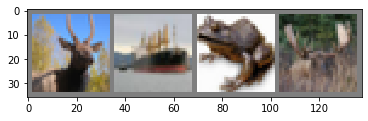

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

## Define a CNN

In [25]:
import torch.nn as nn
import torch.nn.functional as F

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

## Define a Loss function and optimizer

In [31]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network

In [32]:
for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2k mini-batches
            print('[%d, %5d] loss: %.3f'%(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print("Finished Training")

[1,  2000] loss: 2.273
[1,  4000] loss: 1.953
[1,  6000] loss: 1.674
[1,  8000] loss: 1.571
[1, 10000] loss: 1.504
[1, 12000] loss: 1.471
[2,  2000] loss: 1.389
[2,  4000] loss: 1.338
[2,  6000] loss: 1.342
[2,  8000] loss: 1.308
[2, 10000] loss: 1.297
[2, 12000] loss: 1.280
Finished Training


In [33]:
torch.save(net.state_dict(), "./cifar_net.pth")

## Test the network on the test data

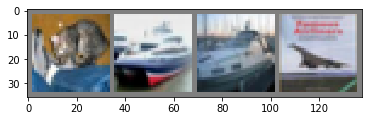

In [34]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [35]:
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

GroundTruth:    cat  ship  ship plane


In [36]:
# net = Net()
# net.load_state_dict(torch.load("./cifar_net.pth"))

In [37]:
outputs = net(images)

In [39]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:   ship   car  ship plane


In [40]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print("Accuracy of te network on the 10000 test images: %d %%"%(100*correct/total))

Accuracy of te network on the 10000 test images: 55 %


In [42]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print("Accuracy of %5s : %2d %%"%(
        classes[i], 100*class_correct[i] / class_total[i]))

Accuracy of plane : 64 %
Accuracy of   car : 63 %
Accuracy of  bird : 42 %
Accuracy of   cat : 41 %
Accuracy of  deer : 52 %
Accuracy of   dog : 51 %
Accuracy of  frog : 54 %
Accuracy of horse : 57 %
Accuracy of  ship : 68 %
Accuracy of truck : 61 %


In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [44]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [45]:
inputs, labels = data[0].to(device), data[1].to(device)